In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-12-30 09:03:26.016381: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-30 09:03:26.416034: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-30 09:03:26.416077: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-30 09:03:27.770346: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

Num GPUs Available:  0


2024-12-30 09:03:28.719968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-12-30 09:03:28.720891: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-30 09:03:28.721268: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-12-30 09:03:28.721554: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-12-30 09:03:28.721827: W tensorflow/c

In [3]:
import pandas as pd
from tsproto.utils import getshap
from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Creating synthetic dataset
We will create a synthetic dataset with two classes. The dataset will be hard to distinguish based on statistical features, but possible with proper prototypical parts extracted.

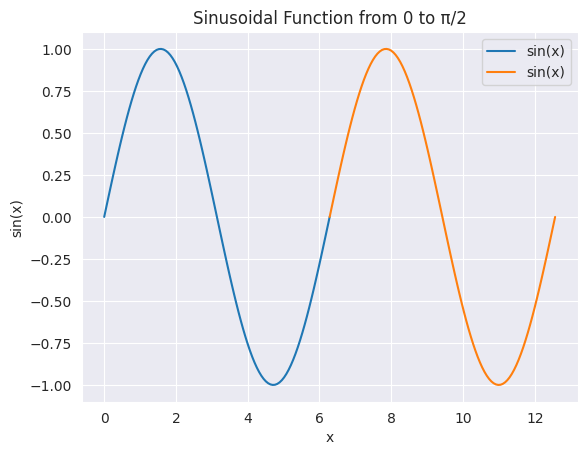

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to π/2
x1 = np.linspace(0, 2*np.pi, 100)
x2 = np.linspace(2*np.pi, 4*np.pi, 100)

# Calculate y values for the sinusoidal function
y1 = np.sin(x1)
y2 = np.sin(x2)

# Plotting the sinusoidal function
plt.plot(x1, y1, label='sin(x)')
plt.plot(x2, y2, label='sin(x)')
plt.title('Sinusoidal Function from 0 to π/2')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [5]:
X3 = np.concatenate((x1,x2))
Y3 = np.concatenate((y1,y2))

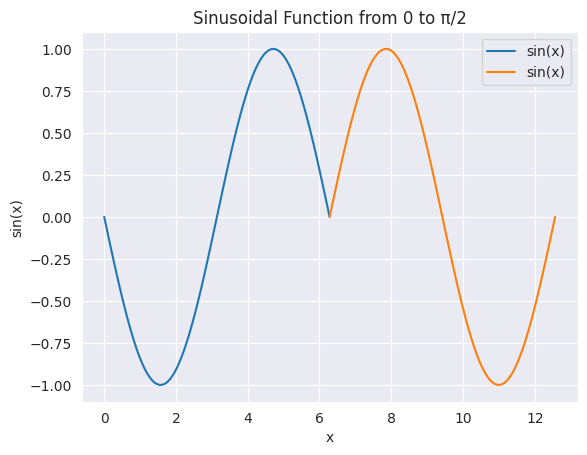

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Generate x values from 0 to π/2
x1 = np.linspace(0, 2*np.pi, 100)
x2 = np.linspace(2*np.pi, 4*np.pi, 100)

# Calculate y values for the sinusoidal function
y1 = np.sin(-x1)
y2 = np.sin(x2)

# Plotting the sinusoidal function
plt.plot(x1, y1, label='sin(x)')
plt.plot(x2, y2, label='sin(x)')
plt.title('Sinusoidal Function from 0 to π/2')
plt.xlabel('x')
plt.ylabel('sin(x)')
plt.legend()
plt.show()

In [7]:
X4 = np.concatenate((x1,x2))
Y4 = np.concatenate((y1,y2))

## Generating sample cases
The difference is in the begining.

In [8]:
x = X3
proto_sin_y = Y3
proto_inversed_sin_y = Y4

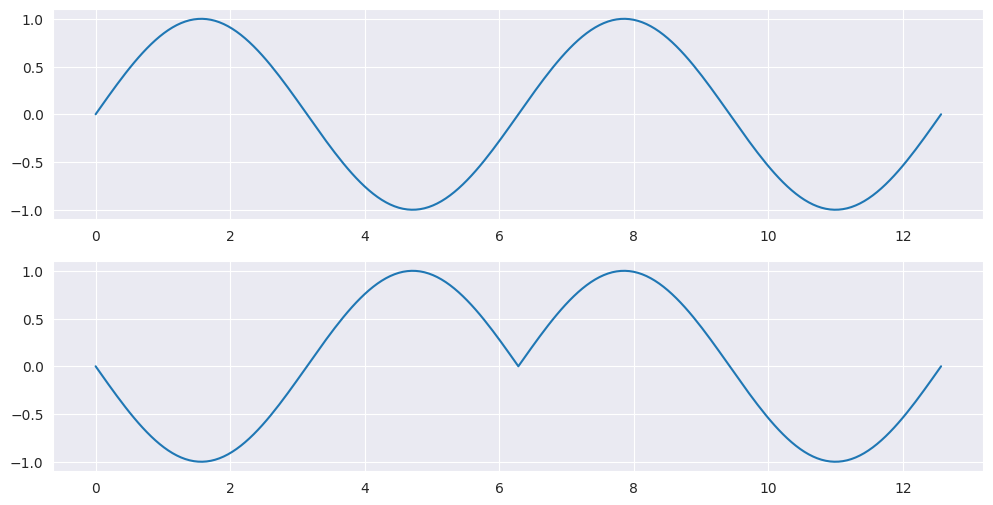

In [9]:
fig, axes =plt.subplots(2,1,figsize=(12,6))
axes[0].plot(x,proto_sin_y)
axes[1].plot(x,proto_inversed_sin_y)

## Generating noise and augmenting signals

In [10]:
noise_power = .9

In [11]:
noise = (np.random.rand(100,len(x))-0.5)*noise_power
noisy_proto_sin_y = noise + proto_sin_y

In [12]:
noise = (np.random.rand(100,len(x))-0.5)*noise_power
noisy_proto_inversed_sin_y = noise + proto_inversed_sin_y

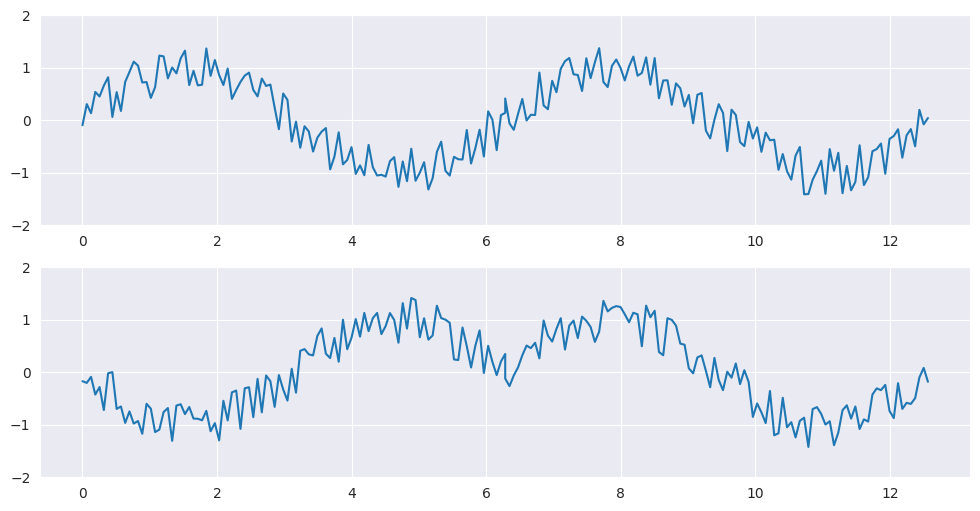

In [13]:
fig, axes =plt.subplots(2,1,figsize=(12,6))
axes[0].plot(x,noisy_proto_sin_y[0])
axes[1].plot(x,noisy_proto_inversed_sin_y[0])
for ax in axes:
    ax.set_ylim([-2, 2])

In [14]:
X=np.concatenate((noisy_proto_sin_y,noisy_proto_inversed_sin_y))
Xy=np.concatenate((np.ones(len(noisy_proto_sin_y))*0,
                   np.ones(len(noisy_proto_inversed_sin_y))*1))

trainX, testX, train_y,test_y = train_test_split(X,Xy)

## Model
We will build simple DNN model (not really needed in this case, but it serves the purpose of demonstration how to deal with more complex cases)

In [15]:
from keras.utils import to_categorical
trainXnn = trainX.reshape(150,1,200)
train_ynn = to_categorical(train_y)
num_classes = len(np.unique(Xy))

In [16]:
import keras
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)
    #add dropout
    input_layer = keras.layers.Dropout(0.5)(input_layer)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(input_layer)
    #conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(conv1)
    #conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=20, padding="same")(conv2)
    #conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)



model = make_model(input_shape=trainXnn.shape[1:])

2024-12-30 09:03:33.235957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["categorical_crossentropy"],
)
history = model.fit(
    trainXnn,
    train_ynn,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
4/4 [==============================] - 1s 90ms/step - loss: 0.6807 - categorical_crossentropy: 0.6807 - val_loss: 0.6433 - val_categorical_crossentropy: 0.6433 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 0.6056 - categorical_crossentropy: 0.6056 - val_loss: 0.5187 - val_categorical_crossentropy: 0.5187 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 0s 21ms/step - loss: 0.4490 - categorical_crossentropy: 0.4490 - val_loss: 0.3154 - val_categorical_crossentropy: 0.3154 - lr: 0.0010
Epoch 4/500
4/4 [==============================] - 0s 20ms/step - loss: 0.2368 - categorical_crossentropy: 0.2368 - val_loss: 0.1174 - val_categorical_crossentropy: 0.1174 - lr: 0.0010
Epoch 5/500
4/4 [==============================] - 0s 20ms/step - loss: 0.0739 - categorical_crossentropy: 0.0739 - val_loss: 0.0244 - val_categorical_crossentropy: 0.0244 - lr: 0.0010
Epoch 6/500
4/4 [==============================] - 0s 21ms/step - loss: 0.0

In [18]:
class ModelWrapper():
    def __init__(self,model):
        self.model=model
    def predict_proba(self,X):
        if isinstance(X, pd.DataFrame):
            X=X.values
        Xnn=X.reshape(X.shape[0],1,X.shape[1])
        return self.model.predict(Xnn)
    def predict(self, X):
        return np.argmax(self.predict_proba(X),axis=1)
clf=ModelWrapper(model)

## SHAP
We calculate SHAP for datasets

In [19]:
fXtrain = trainX.reshape(150,1,200)

In [20]:
shap_version='deep'
bg_size = 1000
stride=10
window_len=10
absshap = True
fXtrain,sv_tr = getshap(model=model, X=fXtrain, y=train_ynn,shap_version=shap_version,bg_size = bg_size, stride=stride, window_len=window_len, absshap = absshap, shuffle=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


## Visualize SHAP
In this section we can see that the network focused on correct parts of the time-series.
In this toy example, it is sufficient to look at SHAP-visualizations to spot the difference, but in case of hundreds of dimensions and more complex problems, prototypes are more useful.

In [21]:
fXtrain,sv_tr = getshap(model=model, X=fXtrain, y=train_ynn,shap_version=shap_version,bg_size = bg_size, stride=stride, window_len=window_len, absshap = False, shuffle=True)
sv_tr.shape

5/5 [==============================] - 0s 2ms/step


(150, 1, 200)

5/5 [==============================] - 0s 1ms/step


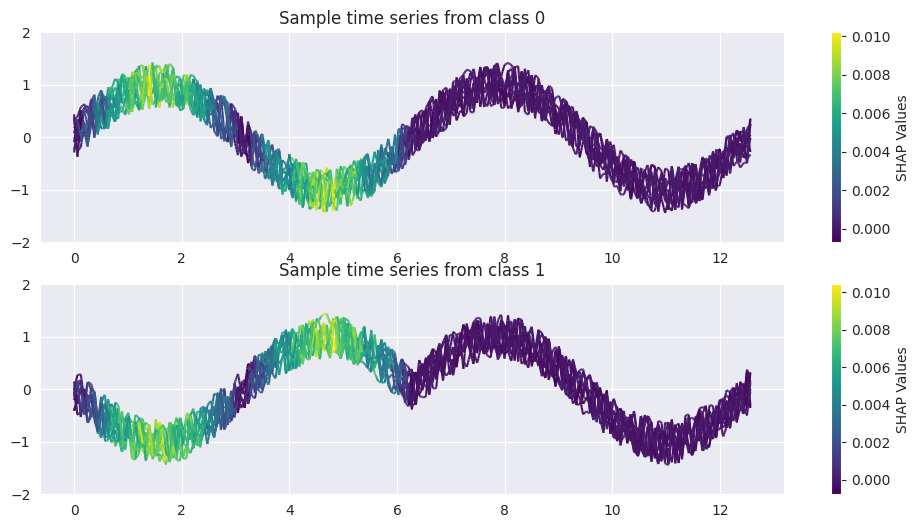

In [22]:
from tsproto.plots import plot_smooth_colored_line
import seaborn as sns

indexer = clf.predict(trainX)
shapclass = []
if absshap == False:
    for i in range(0,len(trainX)):
        best_index = indexer[i]
        shapclass.append([sv_tr[best_index][i,:]])
        
    shapclass=np.concatenate(shapclass)
else:
    shapclass  = sv_tr[:,0,:]
    fig, axes =plt.subplots(2,1,figsize=(12,6))
    for i in range(0,10):
        plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==0][i], color_values=shapclass[train_y==0][i], resolution=1000, ax=axes[0],add_cbar=(i==0))
        plot_smooth_colored_line(x_values=x, y_values=trainX[train_y==1][i], color_values=shapclass[train_y==1][i], resolution=1000, ax=axes[1],add_cbar=(i==0))

for ax in axes:
    ax.set_ylim([-2, 2])

axes[0].set_title('Sample time series from class 0')
axes[1].set_title('Sample time series from class 1')
plt.savefig('c1c2shap.svg', format='svg',bbox_inches='tight')

## TSProto
Now, lets try to apply TSProto to see if it is able to find the prototype and summarize them correctly to show what logical relation is between them and the model prediction

In [23]:
trainXproto = trainX.reshape((trainX.shape[0], trainX.shape[1],1))
shapclassXproto = shapclass.reshape((shapclass.shape[0], shapclass.shape[1],1))

In [24]:
from tsproto.models import *
im  = InterpretableModel()
pe = PrototypeEncoder(clf, n_clusters=2, min_size=50, method='dtw',
                      descriptors=['existance'],
                      global_breakpointing=True,
                      jump=1, pen=1,multiplier=0,n_jobs=-1,
                      verbose=1)
ohe_train, features, target_ohe,weights = pe.fit_transform(trainXproto,shapclassXproto)

acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_train, features, target_ohe,intclf=None, verbose=0, max_depth=2, min_samples_leaf=0.05,
                       weights=None)

ohe_test, features, target_ohe, weights = pe.transform(trainXproto,shapclassXproto)
acc,prec,rec,f1,iclf = im.fit_or_predict(ohe_test, features, target_ohe,intclf=iclf,verbose=0, max_depth=None, min_samples_leaf=0.05,
                       weights=None)

print(f'Fidelity : \n\tACC:{acc}, \n\tPREC:{prec}, \n\tREC:{rec}, \n\tF1:{f1}')  
cc = DecisionTreeClassifier()
cc.fit(trainXproto[:,:,0], clf.predict(trainX))
cp = cc.predict(trainXproto[:,:,0])
f1_raw = f1_score(clf.predict(trainX), cp, average='macro')
print(f'Fidelity  RAW: {f1_raw}')

Dataset shape: (150, 200, 1)
Calculating changepoints...
5/5 [==============================] - 0s 1ms/step
Done in 0.08188676834106445.
Clustering data
Shape of data for clustering: (150, 96, 1)
Clustering data
Done in 5.463399648666382.
OHE time series
['existance']
Done in 0.17553281784057617.
Dataset shape: (150, 200, 1)
Calculating changepoints...
5/5 [==============================] - 0s 1ms/step
Done in 0.06666684150695801.
Clustering data
Shape of data for clustering: (150, 96, 1)
Done in 0.3175933361053467.
OHE time series
['existance']
Done in 0.26292920112609863.
Fidelity : 
	ACC:1.0, 
	PREC:1.0, 
	REC:1.0, 
	F1:1.0
5/5 [==============================] - 0s 2ms/step
Fidelity  RAW: 1.0


## Visualize interpretable model
We can easily see that the TSProto has found the sine wave at the beginning of the sample, marked it as prototype and correctly identified that its existence is enough to treat the sample as a class 1 sample

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


TC: 75 over ccshap: 75
Decision Tree exported to synthetic with embedded histograms successfully.


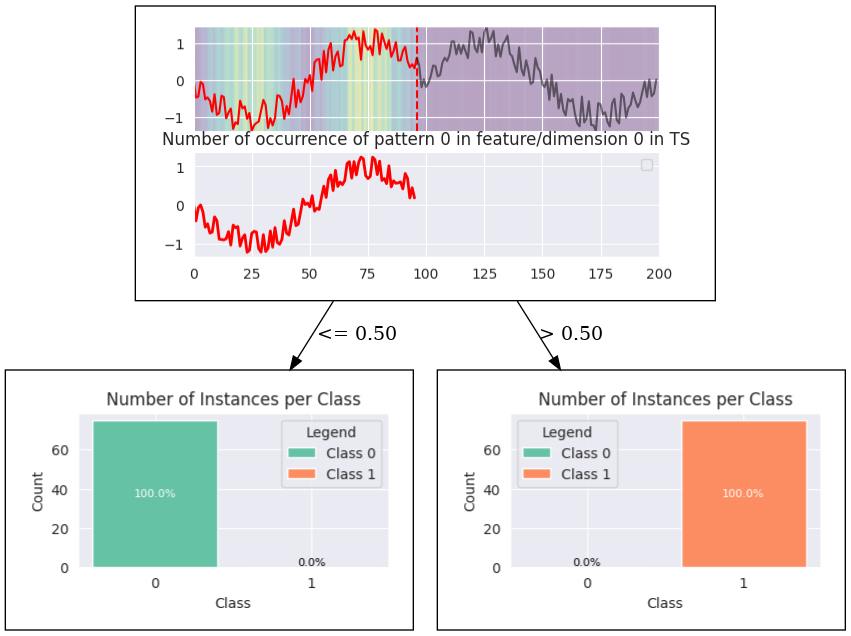

In [31]:
from  tsproto.plots import *

ds_final = ohe_train.copy()
dot = export_decision_tree_with_embedded_histograms(decision_tree=iclf, 
                                              dataset=ds_final, 
                                              target_name='target', 
                                              feature_names=features, 
                                              filename='synthetic', 
                                              proto_encoder=pe, figsize=(6,3))

from IPython.display import SVG, Image
Image('synthetic.png')